*Dataset Visualization*

In [6]:
import scipy.io
import numpy as np

# Load MATLAB file
mat_data = scipy.io.loadmat('graz_data/dataset_BCIcomp1.mat')

# Display available keys (variables)
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Copyright', 'x_train', 'x_test', 'y_train'])


In [8]:
# Extract EEG data and labels
x_train = mat_data['x_train']  # EEG training data
x_test = mat_data['x_test']  # EEG test data
y_train = mat_data['y_train'].flatten()  # Labels (flatten if necessary)

print(f"x_train shape: {x_train.shape}")  # Check dimensions
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")


x_train shape: (1152, 3, 140)
x_test shape: (1152, 3, 140)
y_train shape: (140,)


In [9]:
np.unique(y_train, return_counts=True)


(array([1, 2], dtype=uint8), array([70, 70], dtype=int64))

The dataset has two classes (1 and 2), likely representing left-hand vs. right-hand movement imagery or some other binary classification task.Each class (1 and 2) appears 70 times, which matches the y_train shape (140,).

In [ ]:
print(len(mat_data['x_train'])) #length of x_train. samples 
print(len(mat_data['y_train'])) #length of instances [70-70]. samples 
print(len(mat_data['x_test'])) #length of x_train. samples 

1152
140
1152


In [35]:
print(len(mat_data['x_train']))

1152


In [36]:
for key in mat_data.keys():
    if not key.startswith("__"):  # Ignore MATLAB metadata keys
        print(f"{key}: Type = {type(mat_data[key])}, Shape = {mat_data[key].shape}")


Copyright: Type = <class 'numpy.ndarray'>, Shape = (1,)
x_train: Type = <class 'numpy.ndarray'>, Shape = (1152, 3, 140)
x_test: Type = <class 'numpy.ndarray'>, Shape = (1152, 3, 140)
y_train: Type = <class 'numpy.ndarray'>, Shape = (140, 1)


In [39]:
# Print a sample from each variable
print("x_train sample:", mat_data['x_train'][141, :, :5])  # First trial, all channels, first 5 samples
print("y_train sample:", mat_data['y_train'][:10])  # First 10 labels


x_train sample: [[ 0.01513672 -0.0390625   0.10449219 -0.02001953 -0.02050781]
 [ 0.05322266  0.01806641  0.02685547 -0.03857422  0.01464844]
 [-0.00927734 -0.07568359  0.08496094 -0.01855469  0.03369141]]
y_train sample: [[1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [1]]


Elliptic Bandpass Filter

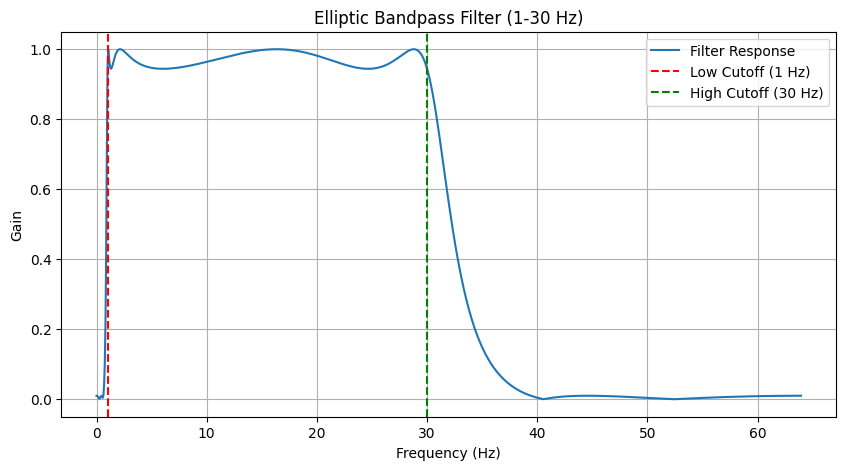

In [40]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Define EEG Sampling Frequency
fs = 128  # Hz (Given in dataset)

# Define Bandpass Filter (Elliptic)
lowcut = 1   # Low cutoff frequency in Hz
highcut = 30  # High cutoff frequency in Hz
order = 4     # Filter order
rp = 0.5      # Passband ripple (dB)
rs = 40       # Stopband attenuation (dB)

# Design Elliptic Filter
b, a = signal.ellip(order, rp, rs, [lowcut, highcut], btype='bandpass', fs=fs)

# Plot the Frequency Response of the Filter
w, h = signal.freqz(b, a, worN=1024, fs=fs)

plt.figure(figsize=(10, 5))
plt.plot(w, abs(h), label="Filter Response")
plt.axvline(lowcut, color='r', linestyle='--', label="Low Cutoff (1 Hz)")
plt.axvline(highcut, color='g', linestyle='--', label="High Cutoff (30 Hz)")
plt.title("Elliptic Bandpass Filter (1-30 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.legend()
plt.grid()
plt.show()


Applying in EEG

In [41]:
# Apply the filter to EEG trials
def apply_filter(eeg_data, b, a):
    """ Apply the elliptic filter to EEG data (trials, channels, timepoints). """
    num_samples, num_channels, num_trials = eeg_data.shape
    filtered_data = np.zeros_like(eeg_data)

    for trial in range(num_trials):  # Loop over trials
        for ch in range(num_channels):  # Loop over channels
            filtered_data[:, ch, trial] = signal.filtfilt(b, a, eeg_data[:, ch, trial])

    return filtered_data

# Apply filter to x_train and x_test
x_train_filtered = apply_filter(x_train, b, a)
x_test_filtered = apply_filter(x_test, b, a)

print("Shape of Filtered x_train:", x_train_filtered.shape)
print("Shape of Filtered x_test:", x_test_filtered.shape)


Shape of Filtered x_train: (1152, 3, 140)
Shape of Filtered x_test: (1152, 3, 140)


Visualize

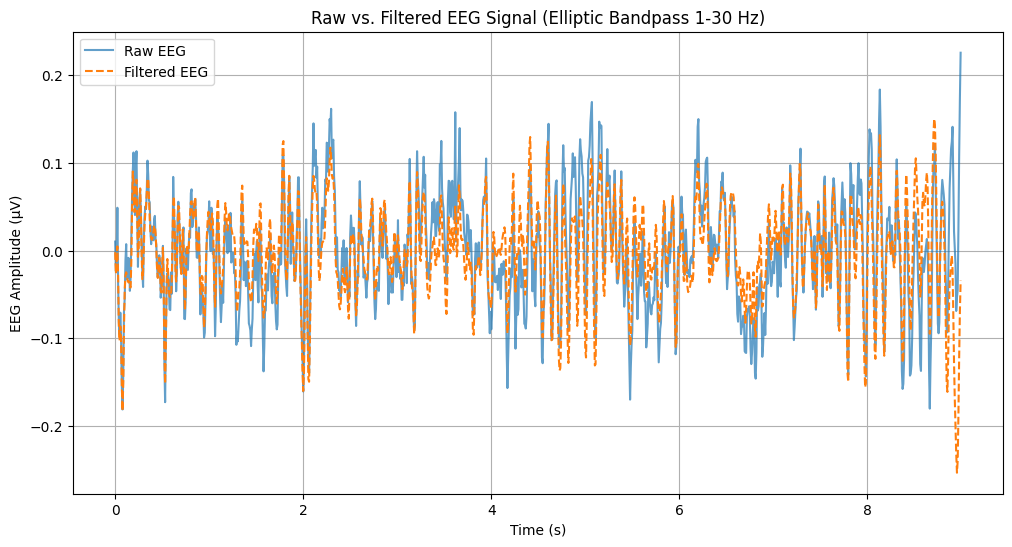

In [42]:
trial_idx = 0  # First trial
channel_idx = 0  # First EEG channel

# Time vector
time = np.arange(x_train.shape[0]) / fs  # Convert samples to time (s)

plt.figure(figsize=(12, 6))
plt.plot(time, x_train[:, channel_idx, trial_idx], label="Raw EEG", alpha=0.7)
plt.plot(time, x_train_filtered[:, channel_idx, trial_idx], label="Filtered EEG", linestyle='dashed')
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("Raw vs. Filtered EEG Signal (Elliptic Bandpass 1-30 Hz)")
plt.legend()
plt.grid()
plt.show()


In [43]:
import scipy.io

filtered_data = {
    'x_train_filtered': x_train_filtered,
    'x_test_filtered': x_test_filtered,
    'y_train': y_train  # Labels remain unchanged
}

scipy.io.savemat("filtered_BCI_data.mat", filtered_data)
print("Filtered data saved successfully!")


Filtered data saved successfully!


In [59]:
print(x_train_filtered)

[[[-0.00187207 -0.02640704 -0.01135824 ... -0.12158414 -0.06943692
   -0.034279  ]
  [ 0.00530103  0.00141567  0.01778238 ... -0.13033958 -0.08214847
   -0.03996002]
  [ 0.00503928 -0.01165013  0.01645959 ... -0.05344521 -0.03358443
   -0.01280029]]

 [[-0.00831065  0.00777294  0.00942616 ...  0.03181221  0.01804882
    0.01974372]
  [ 0.00700612  0.04584014  0.05897145 ... -0.01168616 -0.01445866
    0.00676427]
  [ 0.00020401 -0.01390834 -0.00900486 ... -0.01530455 -0.00692108
    0.02825021]]

 [[-0.02266538 -0.06847256 -0.14596452 ...  0.06240468  0.04975321
    0.0211162 ]
  [-0.01251523 -0.02794996 -0.0551792  ...  0.03105519  0.02797768
    0.03284805]
  [-0.00427938 -0.00478171 -0.03152104 ...  0.03625941  0.05067572
    0.05101908]]

 ...

 [[ 0.0163769   0.07700035  0.09946926 ... -0.07324687 -0.03891269
    0.01471298]
  [-0.01005981  0.0182238   0.030347   ... -0.01148913  0.00202332
    0.03561722]
  [ 0.01080093  0.00707559 -0.00781628 ... -0.0244134  -0.02515344
   -0.00

In [69]:
# Transpose data to match (Trials, Channels, Time)
x_train = np.transpose(x_train_filtered, (0, 1, 2))  # Shape: (140, 3, 1152)
x_test = np.transpose(x_test_filtered, (0, 1, 2))  # Shape: (140, 3, 1152)

print("Reshaped x_train shape:", x_train.shape)  # Expected: (140, 3, 1152)
print("Reshaped x_test shape:", x_test.shape)  # Expected: (140, 3, 1152)


Reshaped x_train shape: (140, 3, 1152)
Reshaped x_test shape: (140, 3, 1152)


In [70]:
# Compute sample indices for 3s - 9s
t_start = int(3 * 128)  # Start at 3s
t_end = int(9 * 128)    # End at 9s

# Extract only the time window of interest
x_train = x_train[:, :, t_start:t_end]  # Shape: (140, 3, 768)
x_test = x_test[:, :, t_start:t_end]  # Shape: (140, 3, 768)

print("Windowed x_train shape:", x_train.shape)  # Expected: (140, 3, 768)
print("Windowed x_test shape:", x_test.shape)  # Expected: (140, 3, 768)


Windowed x_train shape: (140, 3, 768)
Windowed x_test shape: (140, 3, 768)


In [71]:
# Keep only C3 and C4 channels (Drop Cz)
x_train_C3_C4 = x_train[:, [0, 2], :]  # Shape: (140, 2, 768)
x_test_C3_C4 = x_test[:, [0, 2], :]  # Shape: (140, 2, 768)

print("Shape of x_train_C3_C4:", x_train_C3_C4.shape)  # Expected: (140, 2, 768)
print("Shape of x_test_C3_C4:", x_test_C3_C4.shape)  # Expected: (140, 2, 768)


Shape of x_train_C3_C4: (140, 2, 768)
Shape of x_test_C3_C4: (140, 2, 768)


In [72]:
import scipy.io

processed_data = {
    'x_train_C3_C4': x_train_C3_C4,
    'x_test_C3_C4': x_test_C3_C4,
    'y_train': y_train  # Labels remain unchanged
}

scipy.io.savemat("processed_BCI_data.mat", processed_data)
print("Processed EEG data saved successfully!")


Processed EEG data saved successfully!


 filtered, reshaped, windowed, and selected EEG channels (C3 & C4)

Load Processed Data 

In [73]:
import scipy.io
import numpy as np

# Load the processed data
data = scipy.io.loadmat("processed_BCI_data.mat")

# Extract variables
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)
y_train = data['y_train'].flatten()  # Shape: (140,)

print("Loaded Data Shapes:")
print("x_train:", x_train.shape)  # (140, 2, 768)
print("x_test:", x_test.shape)    # (140, 2, 768)
print("y_train:", y_train.shape)  # (140,)


Loaded Data Shapes:
x_train: (140, 2, 768)
x_test: (140, 2, 768)
y_train: (140,)


In [ ]:
Feature 1

In [74]:
import numpy as np

def extract_statistical_features(eeg_data):
    """
    Extracts 12 statistical features per trial:
    - Mean (μX)
    - Standard Deviation (σX)
    - Mean Absolute First Difference (δX)
    - Standardized First Difference (δ̄X)
    - Mean Absolute Second Difference (γX)
    - Standardized Second Difference (γ̄X)
    
    eeg_data: EEG trials (shape: trials x channels x timepoints)
    returns: Feature matrix (shape: trials x 12)
    """
    num_trials, num_channels, num_samples = eeg_data.shape
    features = []

    for trial in range(num_trials):
        trial_features = []
        for ch in range(num_channels):
            X = eeg_data[trial, ch, :]

            # Compute Features
            mean_X = np.mean(X)
            std_X = np.std(X)
            first_diff = np.abs(np.diff(X))
            second_diff = np.abs(np.diff(X, n=2))

            mean_first_diff = np.mean(first_diff)
            std_first_diff = mean_first_diff / (std_X + 1e-10)  # Avoid division by zero
            mean_second_diff = np.mean(second_diff)
            std_second_diff = mean_second_diff / (std_X + 1e-10)

            # Append features
            trial_features.extend([
                mean_X, std_X, mean_first_diff, std_first_diff, mean_second_diff, std_second_diff
            ])
        features.append(trial_features)

    return np.array(features)

# Load Processed EEG Data
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)

# Extract Statistical Features
stat_features_train = extract_statistical_features(x_train)  # Shape: (140, 12)
stat_features_test = extract_statistical_features(x_test)  # Shape: (140, 12)

print("Statistical Features Shape (Train):", stat_features_train.shape)  # Expected: (140, 12)
print("Statistical Features Shape (Test):", stat_features_test.shape)  # Expected: (140, 12)


Statistical Features Shape (Train): (140, 12)
Statistical Features Shape (Test): (140, 12)


2nd Feature Vector

In [78]:
pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB 330.3 kB/s eta 0:00:13
   ---------------------------------------- 0.0/4.2 MB 330.3 kB/s eta 0:00:13
    --------------------------------------- 0.1/4.2 MB 409.6 kB/s eta 0:00:11
    --------------------------------------- 0.1/4.2 MB 492.8 kB/s eta 0:00:09
   - -------------------------------------- 0.2/4.2 MB 751.6 kB/s eta 0:00:06
   -- ------------------------------------- 0.2/4.2 MB 850.1 kB/s eta 0:00:05
   -- ------------------------------------- 0.3/4.2 MB 787.7 kB/s eta 0:00:06
   --- ------------------------------------ 0.3/4.2 MB 941.3 kB/s eta 0:00:05
   --- ------------------------------------ 0.4/4.2 MB 958.4 kB/s eta 0:00:04
   ---- ----------------------------------- 0.5/4.2 MB 1.1 MB/s eta 0:00:04
   ----- ---------------------------------- 0.6/4.2 MB 1.1 MB/s eta 0:00:04
   -----


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
import numpy as np
import pywt

def extract_wavelet_energy_entropy(eeg_data, wavelet='db4', level=3):
    """
    Extracts Wavelet-based Energy & Entropy Features.
    - Uses Daubechies 4 (db4) wavelet with 3-level decomposition.
    - Computes Energy (ENG) and Entropy (ENT) from D3 coefficients.

    eeg_data: EEG trials (shape: trials x channels x timepoints)
    returns: Feature matrix (shape: trials x 4)
    """
    num_trials, num_channels, num_samples = eeg_data.shape
    features = []

    for trial in range(num_trials):
        trial_features = []
        for ch in range(num_channels):
            X = eeg_data[trial, ch, :]
            
            # Apply Wavelet Decomposition
            coeffs = pywt.wavedec(X, wavelet, level=level)

            # Extract D3 coefficients (third level detail)
            D3 = coeffs[1]  

            # Compute Energy
            energy = np.sum(np.square(D3))

            # Compute Entropy
            prob_coeffs = np.square(D3) / (np.sum(np.square(D3)) + 1e-10)  # Normalize
            entropy = -np.sum(prob_coeffs * np.log2(prob_coeffs + 1e-10))  # Shannon Entropy

            trial_features.extend([energy, entropy])
        features.append(trial_features)

    return np.array(features)

# Load Processed EEG Data
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)

# Extract Wavelet-Based Features
wavelet_features_train = extract_wavelet_energy_entropy(x_train)  # Shape: (140, 4)
wavelet_features_test = extract_wavelet_energy_entropy(x_test)  # Shape: (140, 4)

print("Wavelet-Based Energy & Entropy Features Shape (Train):", wavelet_features_train.shape)  # Expected: (140, 4)
print("Wavelet-Based Energy & Entropy Features Shape (Test):", wavelet_features_test.shape)  # Expected: (140, 4)


Wavelet-Based Energy & Entropy Features Shape (Train): (140, 4)
Wavelet-Based Energy & Entropy Features Shape (Test): (140, 4)


3rd Feature

In [80]:
import numpy as np
import pywt

def extract_wavelet_rms(eeg_data, wavelet='db4', level=3):
    """
    Extracts Wavelet-based RMS Features.
    - Uses Daubechies 4 (db4) wavelet with 3-level decomposition.
    - Computes RMS from D3 coefficients.

    eeg_data: EEG trials (shape: trials x channels x timepoints)
    returns: Feature matrix (shape: trials x 2)
    """
    num_trials, num_channels, num_samples = eeg_data.shape
    features = []

    for trial in range(num_trials):
        trial_features = []
        for ch in range(num_channels):
            X = eeg_data[trial, ch, :]
            
            # Apply Wavelet Decomposition
            coeffs = pywt.wavedec(X, wavelet, level=level)

            # Extract D3 coefficients (third level detail)
            D3 = coeffs[1]  

            # Compute RMS
            rms_value = np.sqrt(np.mean(np.square(D3)))

            trial_features.append(rms_value)
        features.append(trial_features)

    return np.array(features)

# Load Processed EEG Data
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)

# Extract Wavelet-Based RMS Features
wavelet_rms_train = extract_wavelet_rms(x_train)  # Shape: (140, 2)
wavelet_rms_test = extract_wavelet_rms(x_test)  # Shape: (140, 2)

print("Wavelet-Based RMS Features Shape (Train):", wavelet_rms_train.shape)  # Expected: (140, 2)
print("Wavelet-Based RMS Features Shape (Test):", wavelet_rms_test.shape)  # Expected: (140, 2)


Wavelet-Based RMS Features Shape (Train): (140, 2)
Wavelet-Based RMS Features Shape (Test): (140, 2)


4th Feature

In [81]:
import numpy as np
import scipy.signal as signal

def extract_psd_features(eeg_data, fs=128):
    """
    Extracts PSD-Based Average Power Features.
    - Uses Welch’s method (Hamming window, 64-sample length).
    - Computes power in Alpha (8-12 Hz) and Beta (18-25 Hz) bands.

    eeg_data: EEG trials (shape: trials x channels x timepoints)
    returns: Feature matrix (shape: trials x 4)
    """
    num_trials, num_channels, num_samples = eeg_data.shape
    freq_bands = [(8, 12), (18, 25)]  # Alpha and Beta bands

    features = []
    for trial in range(num_trials):
        trial_features = []
        for ch in range(num_channels):
            # Compute PSD using Welch's method
            f, Pxx = signal.welch(eeg_data[trial, ch, :], fs=fs, nperseg=64, window='hamming')

            # Compute average power for each band
            band_powers = [np.sum(Pxx[(f >= band[0]) & (f <= band[1])]) for band in freq_bands]
            trial_features.extend(band_powers)
        features.append(trial_features)

    return np.array(features)

# Load Processed EEG Data
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)

# Extract PSD-Based Features
psd_features_train = extract_psd_features(x_train)  # Shape: (140, 4)
psd_features_test = extract_psd_features(x_test)  # Shape: (140, 4)

print("PSD-Based Average Power Features Shape (Train):", psd_features_train.shape)  # Expected: (140, 4)
print("PSD-Based Average Power Features Shape (Test):", psd_features_test.shape)  # Expected: (140, 4)


PSD-Based Average Power Features Shape (Train): (140, 4)
PSD-Based Average Power Features Shape (Test): (140, 4)


5th Feature

In [82]:
import numpy as np
import scipy.signal as signal

def extract_band_power(eeg_data, fs=128):
    """
    Extracts Average Band Power Features.
    - Computes percentage of total power in Alpha (8-12 Hz) and Beta (18-25 Hz) bands.

    eeg_data: EEG trials (shape: trials x channels x timepoints)
    returns: Feature matrix (shape: trials x 4)
    """
    num_trials, num_channels, num_samples = eeg_data.shape
    freq_bands = [(8, 12), (18, 25)]  # Alpha and Beta bands

    features = []
    for trial in range(num_trials):
        trial_features = []
        for ch in range(num_channels):
            # Compute PSD using Welch's method
            f, Pxx = signal.welch(eeg_data[trial, ch, :], fs=fs, nperseg=64, window='hamming')

            # Compute total power
            total_power = np.sum(Pxx)

            # Compute percentage of power in each band
            band_powers = [(np.sum(Pxx[(f >= band[0]) & (f <= band[1])]) / total_power) * 100 for band in freq_bands]
            trial_features.extend(band_powers)
        features.append(trial_features)

    return np.array(features)

# Load Processed EEG Data
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
x_train = data['x_train_C3_C4']  # Shape: (140, 2, 768)
x_test = data['x_test_C3_C4']  # Shape: (140, 2, 768)

# Extract Average Band Power Features
band_power_train = extract_band_power(x_train)  # Shape: (140, 4)
band_power_test = extract_band_power(x_test)  # Shape: (140, 4)

print("Average Band Power Features Shape (Train):", band_power_train.shape)  # Expected: (140, 4)
print("Average Band Power Features Shape (Test):", band_power_test.shape)  # Expected: (140, 4)


Average Band Power Features Shape (Train): (140, 4)
Average Band Power Features Shape (Test): (140, 4)


Combining

In [84]:
import numpy as np

# Combine features into a final feature matrix
X_train = np.hstack((
    stat_features_train, 
    wavelet_features_train, 
    wavelet_rms_train, 
    psd_features_train, 
    band_power_train
))

X_test = np.hstack((
    stat_features_test, 
    wavelet_features_test, 
    wavelet_rms_test, 
    psd_features_test, 
    band_power_test
))

print("Final Feature Set Shape (Train):", X_train.shape)  # Expected: (140, 26)
print("Final Feature Set Shape (Test):", X_test.shape)  # Expected: (140, 26)


Final Feature Set Shape (Train): (140, 26)
Final Feature Set Shape (Test): (140, 26)


******

In [85]:
import numpy as np
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


In [86]:
from sklearn.model_selection import train_test_split

# Splitting into Training (80%) and Validation (20%) sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train Set Shape:", X_train_split.shape)
print("Validation Set Shape:", X_val.shape)


Train Set Shape: (112, 26)
Validation Set Shape: (28, 26)


In [87]:
from sklearn.svm import SVC

# Train a C-SVC with an RBF kernel
model = SVC(kernel="rbf", C=1, gamma="scale")
model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import accuracy_score
print("Validation Accuracy:", accuracy_score(y_val, y_pred) * 100)


Validation Accuracy: 89.28571428571429


We successfully trained an SVM (C-SVC with RBF kernel) on the extracted EEG features and achieved a validation accuracy  of 89.28571428571429

In [88]:
# Predict on test data
y_test_pred = model.predict(X_test)

# Print first 10 predictions
print("Predicted Test Labels (first 10):", y_test_pred[:10])


Predicted Test Labels (first 10): [2 2 2 2 1 1 2 1 1 2]


In [89]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
}

# Grid Search for best parameters
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5)
grid_search.fit(X_train_split, y_train_split)

# Print best parameters
print("Best Parameters for SVM:", grid_search.best_params_)

# Retrain best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)

# Evaluate tuned model
print("Tuned Validation Accuracy:", accuracy_score(y_val, y_pred_best) * 100)


Best Parameters for SVM: {'C': 1, 'gamma': 'scale'}
Tuned Validation Accuracy: 89.28571428571429


********

In [91]:
import numpy as np
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
# Assuming y_train is available
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
y_train = data['y_train'].flatten()  # Convert from shape (140,1) to (140,)

# Train-test split (80% training, 20% validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train Set Shape:", X_train_split.shape)
print("Validation Set Shape:", X_val.shape)


Train Set Shape: (112, 26)
Validation Set Shape: (28, 26)


In [92]:
# Define SVM variants
svm_variants = {
    "C-SVC Linear": SVC(kernel="linear", C=1),
    "C-SVC Polynomial": SVC(kernel="poly", C=1, degree=3),
    "C-SVC RBF": SVC(kernel="rbf", C=1, gamma="scale"),
    "C-SVC Sigmoid": SVC(kernel="sigmoid", C=1),
    "Nu-SVC Linear": NuSVC(kernel="linear", nu=0.5),
    "Nu-SVC Polynomial": NuSVC(kernel="poly", nu=0.5, degree=3),
    "Nu-SVC RBF": NuSVC(kernel="rbf", nu=0.5, gamma="scale"),
    "Nu-SVC Sigmoid": NuSVC(kernel="sigmoid", nu=0.5)
}

# Train and evaluate each model
for name, model in svm_variants.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val)
    
    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_val, y_pred))



Training C-SVC Linear...
C-SVC Linear Accuracy: 85.71%
              precision    recall  f1-score   support

           1       0.75      0.90      0.82        10
           2       0.94      0.83      0.88        18

    accuracy                           0.86        28
   macro avg       0.84      0.87      0.85        28
weighted avg       0.87      0.86      0.86        28


Training C-SVC Polynomial...
C-SVC Polynomial Accuracy: 89.29%
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.94      0.89      0.91        18

    accuracy                           0.89        28
   macro avg       0.88      0.89      0.89        28
weighted avg       0.90      0.89      0.89        28


Training C-SVC RBF...
C-SVC RBF Accuracy: 89.29%
              precision    recall  f1-score   support

           1       0.77      1.00      0.87        10
           2       1.00      0.83      0.91        18

    accuracy

In [93]:
# Define parameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
    "degree": [2, 3, 4]
}

# Grid Search for RBF SVM
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid={"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}, cv=5)
grid_search.fit(X_train_split, y_train_split)

print("Best Parameters for RBF SVM:", grid_search.best_params_)


Best Parameters for RBF SVM: {'C': 1, 'gamma': 'scale'}


Now MLP

In [98]:
X_train = np.hstack((
    stat_features_train, 
    wavelet_features_train, 
    wavelet_rms_train, 
    psd_features_train, 
    band_power_train
))

X_test = np.hstack((
    stat_features_test, 
    wavelet_features_test, 
    wavelet_rms_test, 
    psd_features_test, 
    band_power_test
))

print("Final Feature Set Shape (Train):", X_train.shape)  # Expected: (140, 26)
print("Final Feature Set Shape (Test):", X_test.shape)  # Expected: (140, 26)


Final Feature Set Shape (Train): (140, 26)
Final Feature Set Shape (Test): (140, 26)


In [99]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [100]:
# Assuming y_train is available
import scipy.io
data = scipy.io.loadmat("processed_BCI_data.mat")
y_train = data['y_train'].flatten()  # Convert shape (140,1) to (140,)

# Split into Training (80%) and Validation (20%) sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train Set Shape:", X_train_split.shape)
print("Validation Set Shape:", X_val.shape)


Train Set Shape: (112, 26)
Validation Set Shape: (28, 26)


In [101]:
# Define MLP Model
mlp = MLPClassifier(hidden_layer_sizes=(26,), activation='relu', solver='sgd',
                    learning_rate_init=0.7, momentum=0.29, max_iter=200, random_state=42)

# Train the MLP model
mlp.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred = mlp.predict(X_val)

# Evaluate model performance
val_acc = accuracy_score(y_val, y_pred)
print(f"MLP Validation Accuracy: {val_acc * 100:.2f}%")
print(classification_report(y_val, y_pred))


MLP Validation Accuracy: 35.71%
              precision    recall  f1-score   support

           1       0.36      1.00      0.53        10
           2       0.00      0.00      0.00        18

    accuracy                           0.36        28
   macro avg       0.18      0.50      0.26        28
weighted avg       0.13      0.36      0.19        28



c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Predict on X_test

In [102]:
# Predict on test data
y_test_pred = mlp.predict(X_test)

# Print first 10 predictions
print("Predicted Test Labels (first 10):", y_test_pred[:10])


Predicted Test Labels (first 10): [1 1 1 1 1 1 1 1 1 1]


Lets Improve

In [103]:
from sklearn.preprocessing import StandardScaler

# Standardize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)


In [104]:
# Define an improved MLP Model
mlp_improved = MLPClassifier(
    hidden_layer_sizes=(26,), activation='relu', solver='adam',
    learning_rate_init=0.01, max_iter=1000, random_state=42
)

# Train the improved MLP model
mlp_improved.fit(X_train_scaled, y_train_split)

# Predict on validation set
y_pred_improved = mlp_improved.predict(X_val_scaled)

# Evaluate model performance
val_acc_improved = accuracy_score(y_val, y_pred_improved)
print(f"Improved MLP Validation Accuracy: {val_acc_improved * 100:.2f}%")
print(classification_report(y_val, y_pred_improved))


Improved MLP Validation Accuracy: 75.00%
              precision    recall  f1-score   support

           1       0.60      0.90      0.72        10
           2       0.92      0.67      0.77        18

    accuracy                           0.75        28
   macro avg       0.76      0.78      0.75        28
weighted avg       0.81      0.75      0.75        28



TypeError: MLPClassifier.__init__() got an unexpected keyword argument 'class_weight'

In [107]:
# Scale the test set using the same scaler
X_test_scaled = scaler.transform(X_test)

# Predict on test data
y_test_pred = mlp_improved.predict(X_test_scaled)

# Print first 10 predictions
print("Predicted Test Labels (first 10):", y_test_pred[:10])


Predicted Test Labels (first 10): [2 2 2 2 1 1 2 1 1 2]


ROC Curve & AUC Score

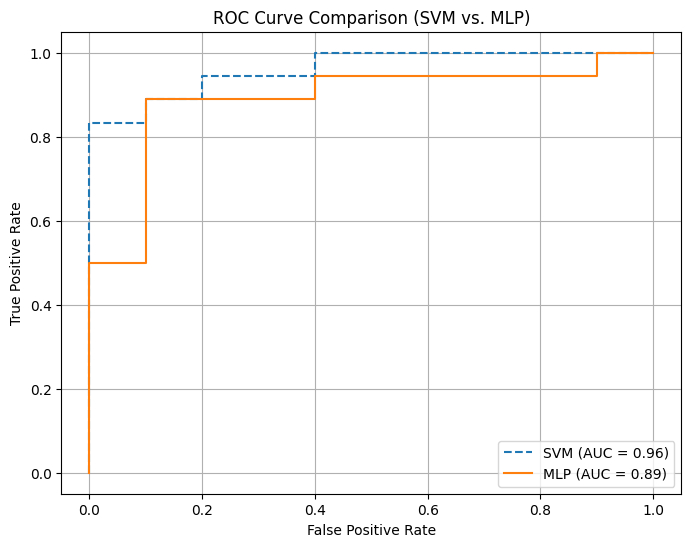

In [109]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for ROC Curve
y_proba_svm = model.decision_function(X_val)  # SVM decision function
y_proba_mlp = mlp_improved.predict_proba(X_val_scaled)[:, 1]  # Probability of Class 2

# Compute ROC Curves, setting pos_label=2
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_proba_svm, pos_label=2)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val, y_proba_mlp, pos_label=2)

# Compute AUC Scores
auc_svm = auc(fpr_svm, tpr_svm)
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC Curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})", linestyle='--')
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.2f})", linestyle='-')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (SVM vs. MLP)")
plt.legend()
plt.grid()
plt.show()


In [110]:
from scipy.stats import ttest_rel

# Perform Paired t-Test
t_stat, p_value = ttest_rel(y_pred, y_pred_improved)
print(f"T-test statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

# Decision
if p_value < 0.05:
    print("SVM and MLP have statistically significant performance differences.")
else:
    print("No significant difference between SVM and MLP performance.")


T-test statistic: 4.837, p-value: 0.000
SVM and MLP have statistically significant performance differences.


In [111]:
import shap

# Initialize SHAP Explainer for MLP
explainer = shap.Explainer(mlp_improved.predict, X_val_scaled)
shap_values = explainer(X_val_scaled)

# Plot feature importance
shap.summary_plot(shap_values, X_val_scaled, feature_names=["Stat1", "Stat2", ..., "BandP4"])


ModuleNotFoundError: No module named 'shap'

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,)  and requested shape (26,)

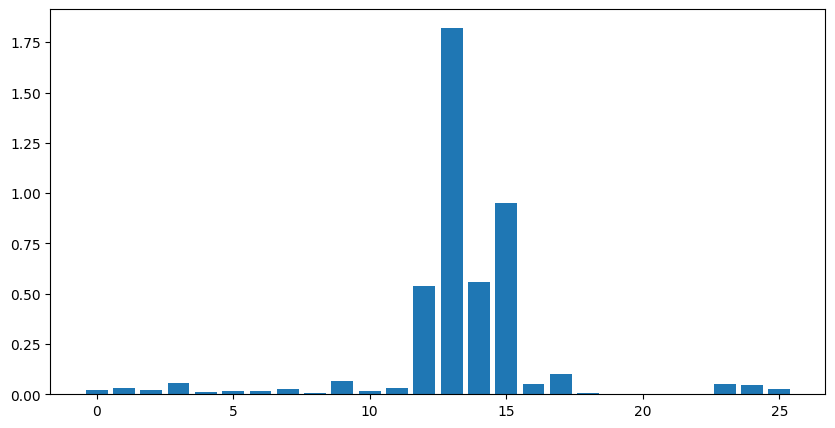

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Train a Linear SVM model (for feature importance)
svm_linear = SVC(kernel="linear", C=1)
svm_linear.fit(X_train_split, y_train_split)

# Get feature importance from SVM coefficients
feature_importance_svm = np.abs(svm_linear.coef_).flatten()

# Feature names (Optional: Update based on actual feature names)
feature_names = ["Stat1", "Stat2", ..., "BandP4"]

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importance_svm)), feature_importance_svm, tick_label=feature_names)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance (SVM - Linear Kernel)")
plt.xticks(rotation=90)
plt.show()


In [113]:
# Define feature subsets
FAP_train = psd_features_train  # (140, 4)
FBP_train = band_power_train  # (140, 4)
FW_train = wavelet_features_train  # (140, 4)
FRMS_train = wavelet_rms_train  # (140, 2)
FS_train = stat_features_train  # (140, 12)
FALL_train = X_train  # (140, 26) - Full feature set

FAP_test = psd_features_test
FBP_test = band_power_test
FW_test = wavelet_features_test
FRMS_test = wavelet_rms_test
FS_test = stat_features_test
FALL_test = X_test


CLASSIFICATION RESULTS FOR SVM and MLP


Feature-Based Accuracy and ROC Area for SVM and MLP:
Feature Set  SVM Accuracy  SVM AUC  MLP Accuracy  MLP AUC
        FAP      0.785714 0.902778      0.357143 0.927778
        FBP      0.857143 0.922222      0.857143 0.950000
         FW      0.857143 0.927778      0.892857 0.983333
       FRMS      0.821429 0.927778      0.857143 0.988889
         FS      0.357143 0.905556      0.821429 0.961111
       FALL      0.892857 0.961111      0.785714 0.911111


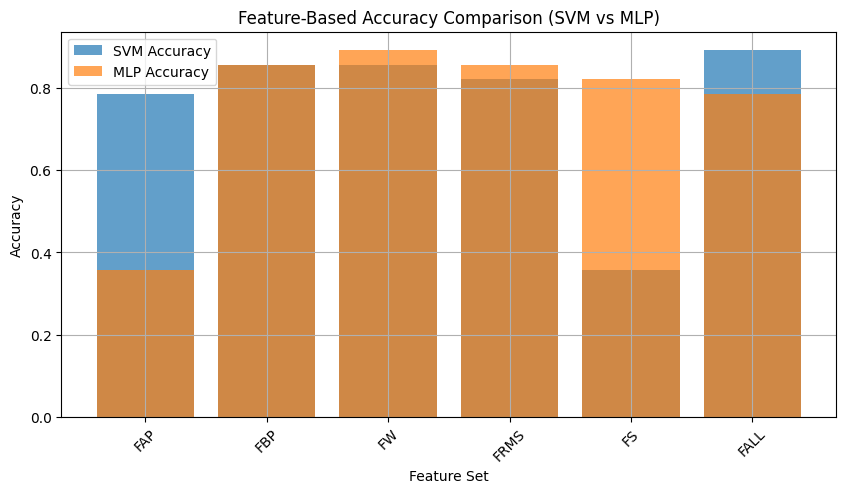

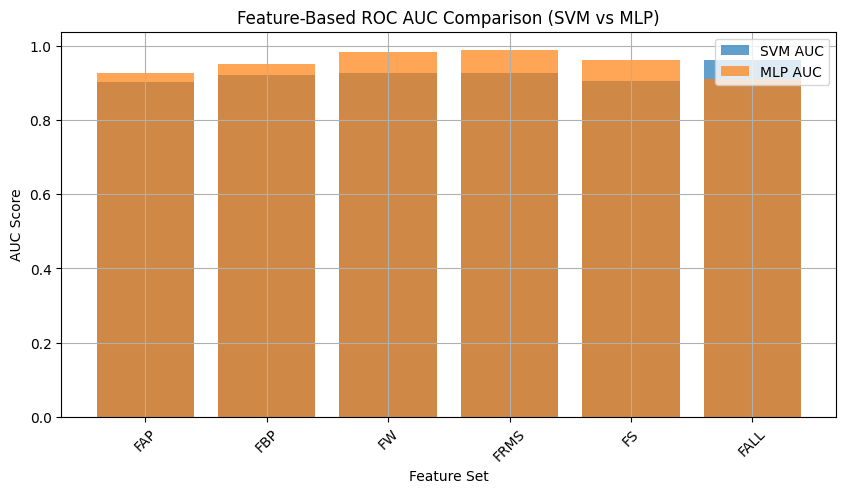

In [115]:
# Convert results to a DataFrame for visualization
import pandas as pd

results_df = pd.DataFrame(results, columns=["Feature Set", "SVM Accuracy", "SVM AUC", "MLP Accuracy", "MLP AUC"])

# Print results in a formatted way
print("\nFeature-Based Accuracy and ROC Area for SVM and MLP:")
print(results_df.to_string(index=False))  # Display without index

# Optionally, save to CSV for later analysis
results_df.to_csv("feature_based_results.csv", index=False)

# Plot results for better visualization
import matplotlib.pyplot as plt

# Plot SVM vs MLP Accuracy
plt.figure(figsize=(10, 5))
plt.bar(results_df["Feature Set"], results_df["SVM Accuracy"], label="SVM Accuracy", alpha=0.7)
plt.bar(results_df["Feature Set"], results_df["MLP Accuracy"], label="MLP Accuracy", alpha=0.7)
plt.xlabel("Feature Set")
plt.ylabel("Accuracy")
plt.title("Feature-Based Accuracy Comparison (SVM vs MLP)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Plot SVM vs MLP AUC
plt.figure(figsize=(10, 5))
plt.bar(results_df["Feature Set"], results_df["SVM AUC"], label="SVM AUC", alpha=0.7)
plt.bar(results_df["Feature Set"], results_df["MLP AUC"], label="MLP AUC", alpha=0.7)
plt.xlabel("Feature Set")
plt.ylabel("AUC Score")
plt.title("Feature-Based ROC AUC Comparison (SVM vs MLP)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
